In [1]:
import tensorflow as tf
import pandas as pd
import seaborn as sns
import re
from sklearn.svm import SVR
from sklearn.feature_selection import SelectFromModel, f_regression, RFE, SelectKBest, VarianceThreshold
from sklearn.svm import LinearSVC
from sklearn import linear_model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from matplotlib.pyplot import figure

In [2]:
pd.set_option("display.max_rows", 10)
pd.set_option("display.max_columns", 999)
figure(figsize=(20, 10), dpi=80)

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

# Preprocessing

In [3]:
def split_data(X, y, train_perc, timestep):
    """
    split train dan testing
    Input :
        X = 
        y = 
        train_perc = persentase data train
    Output :
        X_train
        y_train
        X_test
        y_test
    """
    train_size = int(len(X)*train_perc)
    X_tr = X[:train_size].reset_index().drop(columns='index')
    y_tr = y[:train_size].reset_index().drop(columns='index')
    X_test = X[train_size-timestep:].reset_index().drop(columns='index')
    y_test = y[train_size-timestep:].reset_index().drop(columns='index')
    return X_tr, y_tr, X_test, y_test

In [4]:
def low_variance(data, threshold=(.8 * (1 - .8))):
    """
    Remove features from the data where the variance is low
    Input :
        data : data we want to clean
        threshold : p(1-p) where p is percentage where the features have more than p% of the same values.
    Output :
        dataframe with no more low variance features
    """
    select = VarianceThreshold(threshold=(.8 * (1 - .8)))
    select.fit(data)
    features = select.get_feature_names_out(input_features=data.columns)
    data = select.transform(data)
    return pd.DataFrame(data, columns=features)

In [5]:
def windowing_dataset(X, y, timelag, kind):
    seq_x = []
    seq_y = []        
    for i in range(0,len(X)-timelag):
        seq_x.append(X.iloc[i:i+timelag].to_numpy())
        if kind == 'univariate':
            seq_y.append(X.iloc[i+timelag])
        else:
            seq_y.append(y.iloc[i+timelag])
    seq_x = np.array(seq_x)
    seq_y = np.array(seq_y)
    if len(seq_x.shape) <3:
        seq_x = np.reshape(seq_x, (seq_x.shape[0], 1, seq_x.shape[1]))  
    return seq_x, seq_y

In [6]:
df = pd.read_csv('D:/Kuliah/SEM7/TA1/data/data throughput.csv', sep=';')
data = df[df['eNodeB Name']=='103437_AstanaJapura_Bunte_MBTS']
data = data.rename(columns={
        'User DL Average Throughput_LTE(kB/s)' : 'dl_avg',
        'User UL Average Throughput_LTE(kB/s)' : 'ul_avg',
        'Cell DL Peak Throughput_LTE(MB/s)' : 'dl_peak',
        'Cell UL Peak Throughput_LTE(MB/s)' : 'ul_peak'
})
data['Time']=pd.to_datetime(data['Time'])
data = data.reset_index()[data.columns[1:]] 
for key,val in data.dtypes.items():
    if val != 'float64':
        try:
            data[key] = data[key].apply(lambda x:x.replace('NIL','0').replace('%','').replace('/','')).astype('float')
        except:
            continue

In [7]:
data = data.drop(columns=['eNodeB Name'])
data = data.fillna(method='bfill')
data = low_variance(data)
#X_tr, y_tr, X_eval, y_eval = split_data(data, 'dl_avg', 0.8)

# Feature Selection

In [8]:
class Corr_selection():
    """
    Fungsi buat feature selection sebelum modeling
    input :
        df = data features yang mau dicari 
        target = target column names
        n_features = number of features to be included
        threshold = threshold to be included
    
    output :
        df = df yang sudah ditransformasi
    Jika memakai automatic maka menggunakan top 10 feature dengan abs(korelasi) terbesar
    """
    def __init__(self):
        pass
    
    def set_params(self, n_features, threshold):
        self.n_features = n_features
        self.threshold = threshold
        
    def fit(self, X, y):
        self.df = pd.concat([X,y], axis=1)
        self.corr = self.df.corr()
        self.sorted_corr = self.corr[y.name].apply(abs).sort_values(ascending=False).drop(y.name)[:self.n_features]
        if self.threshold!=None:
            mask = self.sorted_corr>self.threshold
            self.sorted_corr = self.sorted_corr[mask]
            
    def get_feature_names_out(self,input_features):
        return self.sorted_corr.index
    
    def transform(self,X):
        return X[self.sorted_corr.index]

In [9]:
def feature_selection(X, y, how, **params):
    """
    make feature selection to reduce the columns
    Input :
        X : dataframe to be reduces
        y : dataframe that have target variable
        how : feature selection type
        n_features : number of features to be kept
    Output :
        dataframe transformed
        
    For 
    SelectKBest :
        Input :
            score_func : score function to used (
                f_classiff,  chi2, etc
            )
            k : top k features
    RFE :
        Input :
            estimator : model to see the feature importance
            n_features_to_select : features to included (if none then half the features will included)
            step : number of features to removed each step (if 0<step<1 then will become percentage)
    SelectFromModel :
        Input :
            estimator : model to see the feature importance
            threshold : feature importance to be included (can also be mean,median)
                        if none then use 1e-5
            max_features : maximum number of features used. To only select based on max_features, set threshold=-np.inf
                        
    """
    selection_type = {
        'SelectKBest' : SelectKBest(),#univariate selection
        'RFE' : RFE(estimator = SVR(kernel="linear")),#recursive feature extraction
        'SelectFromModel' : SelectFromModel(estimator = SVR(kernel="linear")),#feature importance
        'Correlation' : Corr_selection(),
        'PCA' : PCA()
    }
    #print(selection_type[how])
    select = selection_type[how]
    select.set_params(**params)
    select.fit(X,y)
    if how == 'PCA':
        features = [f'pca_{i}' for i in range(params['n_components'])]
    else:
        features = select.get_feature_names_out(input_features=X.columns)
    X = select.transform(X)
    return pd.DataFrame(X, columns=features)

# Model

In [10]:
def compile_and_fit(model, X_tr, y_tr, epochs, verbose, patience=5):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='mean_squared_error',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.Huber(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanSquaredError()])

    history = model.fit(X_tr, y_tr, epochs=epochs,
                      callbacks=[early_stopping],verbose=verbose)
    return history

In [11]:
def infer(X_test, model):
    """
    khusus univariate
    """
    predicted_list = []
    init = X_test[0].reshape(1, X_test.shape[1], X_test.shape[2])
    for i in range(len(X_test)):
        predicted = model_dense.predict(init)
        init = init[0][1:]
        init = np.append(init, predicted)
        init = init.reshape(1, X_test.shape[1], X_test.shape[2])
        predicted_list.append(predicted[0][0])
    return np.array(predicted_list)

In [12]:
def evaluate(y_true, y_pred, transformer, scale):
    #original
    ori_predict = transformer.inverse_transform(y_pred)
    ori_y = transformer.inverse_transform(y_true.reshape(-1,1))
    
    #calculate mae
    norm_mae = mean_absolute_error(predict[:,0], y_test)
    ori_mae = mean_absolute_error(ori_predict, ori_y)
    
    #calculate mse
    norm_mse = mean_squared_error(predict[:,0], y_test)
    ori_mse = mean_squared_error(ori_predict, ori_y)
    
    #calculate r-squared
    norm_r_squared = r2_score(predict[:,0], y_test)
    ori_r_squared = r2_score(ori_predict, ori_y)
    
    eval_holder = {
        'norm_mae' : norm_mae,
        'ori_mae' : ori_mae,
        'norm_mse' : norm_mse,
        'ori_mse' : ori_mse,
        'norm_r_squared' : norm_r_squared,
        'ori_r_squared' : ori_r_squared
    }
    return eval_holder

# Testing ground

In [86]:
#test feature selection
target = 'dl_avg'
select = 'a'
n_feature=5
y = data[target]
X = data.drop(target, axis=1)
if select == 'Correlation':
    X_filtered = feature_selection(X, y, how=select, n_features=n_feature, threshold=None)
elif select == 'SelectKBest':
    X_filtered = feature_selection(X, y, how=select, k=n_feature)
elif select == 'RFE':
    estimator = RandomForestRegressor(max_depth=5, random_state=42)
    X_filtered = feature_selection(X, y, how=select, estimator=estimator, n_features_to_select=n_feature, step=0.5)
elif select == 'PCA':
    X_filtered = feature_selection(X, y, how='PCA', n_components=n_feature, random_state=42)
else:
    estimator = RandomForestRegressor(max_depth=5, random_state=42)
    X_filtered = feature_selection(X, y, how='SelectFromModel', estimator=estimator, threshold=-np.inf, max_features=n_feature)
X_filtered = pd.DataFrame(StandardScaler().fit_transform(X_filtered), columns=X_filtered.columns)

In [87]:
#test preprocess multivariate
timestep = 3
train_perc = 0.8
X_tr, y_tr, X_test, y_test = split_data(X_filtered, y, train_perc, timestep)
X_tr, y_tr = windowing_dataset(X_tr, y_tr, timestep, 'multivariate')
X_test, y_test = windowing_dataset(X_test, y_test, timestep, 'multivariate')

In [187]:
#test preprocess univariate
timestep = 3
train_perc = 0.8
X, y = data[target], data[target]
X_tr, y_tr, X_test, y_test = split_data(X, y, train_perc, timestep)
X_tr, y_tr = windowing_dataset(X_tr, y_tr, timestep, 'univariate')
X_test, y_test = windowing_dataset(X_test, y_test, timestep, 'univariate')

In [63]:
#test normalisasi dulu
target = 'dl_avg'
train_perc = 0.8
timestep = 5
transformer = RobustScaler().fit(data[target].to_numpy().reshape(-1, 1))
norm = transformer.transform(data[target].to_numpy().reshape(-1, 1))
X, y = pd.Series(norm[:,0]), pd.Series(norm[:,0])
X_tr, y_tr, X_test, y_test = split_data(X, y, train_perc, timestep)
X_tr, y_tr = windowing_dataset(X_tr, y_tr, timestep, 'univariate')
X_test, y_test = windowing_dataset(X_test, y_test, timestep, 'univariate')

In [238]:
#test train model lstm 
epochs = 1000
verbose = 0
model_lstm = tf.keras.Sequential([
                        tf.keras.layers.LSTM(8, return_sequences=True),
                        tf.keras.layers.LSTM(4),
                        tf.keras.layers.Dense(1)
                    ]) 
history = compile_and_fit(model_lstm, X_tr, y_tr, epochs, verbose, patience=5)

In [70]:
#test train model dense 
epochs = 1000
verbose = 0
model_dense = tf.keras.Sequential([
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(units=8, activation='relu'),
                tf.keras.layers.Dense(units=4, activation='relu'),
                tf.keras.layers.Dense(units=1)
            ])
history = compile_and_fit(model_dense, X_tr, y_tr, epochs, verbose, patience=5)

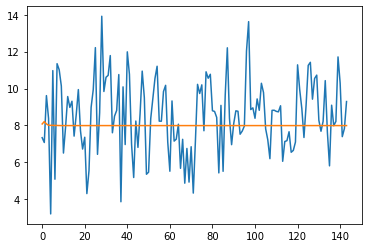

In [246]:
y_predict = infer(X_test, model_lstm)
ori_predict = transformer.inverse_transform(y_predict.reshape(-1,1))
ori_y = transformer.inverse_transform(y_test.reshape(-1,1))
plt.plot([i for i in range(len(ori_y))], ori_y)
plt.plot([i for i in range(len(ori_predict))], ori_predict)

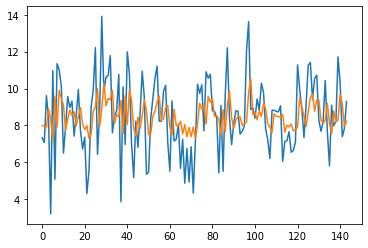

In [247]:
y_predict = model_lstm.predict(X_test)
ori_predict = transformer.inverse_transform(y_predict.reshape(-1,1))
ori_y = transformer.inverse_transform(y_test.reshape(-1,1))
plt.plot([i for i in range(len(ori_y))], ori_y)
plt.plot([i for i in range(len(ori_predict))], ori_predict)

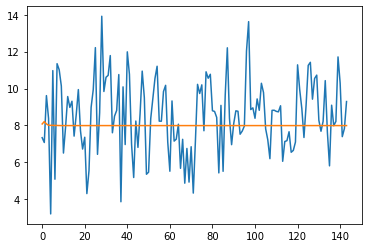

In [248]:
y_predict = infer(X_test, model_dense)
ori_predict = transformer.inverse_transform(y_predict.reshape(-1,1))
ori_y = transformer.inverse_transform(y_test.reshape(-1,1))
plt.plot([i for i in range(len(ori_y))], ori_y)
plt.plot([i for i in range(len(ori_predict))], ori_predict)

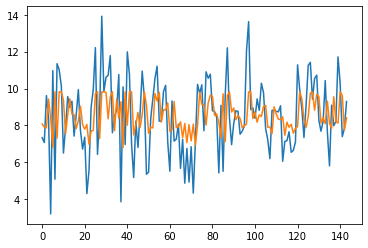

In [249]:
y_predict = model_dense.predict(X_test)
ori_predict = transformer.inverse_transform(y_predict.reshape(-1,1))
ori_y = transformer.inverse_transform(y_test.reshape(-1,1))
plt.plot([i for i in range(len(ori_y))], ori_y)
plt.plot([i for i in range(len(ori_predict))], ori_predict)

# Pipeline

## Univariable

In [72]:
#pipeline data univariate
target = ['dl_avg', 'ul_avg']
predicted = {
    'target':[],
    'timelag':[],
    'model':[],
    'mae':[]
}
timelags = [1,2,3,5,10]
train_perc = 0.8
test_perc = 0.1
eval_perc = 0.1
train_size = int(len(X)*train_perc)
eval_size = int(len(X)*eval_perc) + train_size
test_size = int(len(X)*test_perc) + train_size + eval_size

for t in target:
    for time in timelags:
        X = data[t]
        X,y = windowing_univariate(X, time)
        X_tr, y_tr = X[:train_size], y[:train_size]
        X_eval, y_eval = X[train_size:eval_size], y[train_size:eval_size]
        X_test, y_test = X[eval_size:test_size], y[eval_size:test_size]
        models = {
            'LSTM' : tf.keras.Sequential([
                        tf.keras.layers.LSTM(8, return_sequences=True),
                        tf.keras.layers.LSTM(4),
                        tf.keras.layers.Dense(1)
                    ]),
            'dense' : tf.keras.Sequential([
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(units=8, activation='relu'),
                tf.keras.layers.Dense(units=4, activation='relu'),
                tf.keras.layers.Dense(units=1)
            ])
        }
        for model in models:
            history = compile_and_fit(models[model], X_tr, y_tr, X_eval, y_eval, epochs=10000, verbose=0)
            predict = models[model].predict(X_test)
            mae = mean_absolute_error(predict[:,0], y_test)
            predicted['target'].append(t)
            predicted['timelag'].append(time)
            predicted['model'].append(model)
            predicted['mae'].append(mae)

In [18]:
data['dl_avg'].name

'dl_avg'

In [22]:
test = data['dl_avg']
transformer = RobustScaler().fit(test.to_numpy().reshape(-1, 1))
norm = transformer.transform(test.to_numpy().reshape(-1, 1))
pd.DataFrame(norm, columns = [test.name])

,dl_avg
0,-0.704557
1,0.474113
2,1.273116
3,2.504836
4,1.011556
...,...
714,1.231288
715,0.675051
716,-0.465245
717,-0.291578


In [73]:
pd.DataFrame(predicted).to_csv('full_results_univariate.csv', index=False)

In [74]:
result = pd.read_csv('full_results_univariate.csv').sort_values(by='mae')
result[result['target']=='dl_avg']

,target,timelag,model,mae
1,dl_avg,1,dense,1.247568
8,dl_avg,10,LSTM,1.284663
6,dl_avg,5,LSTM,1.305107
7,dl_avg,5,dense,1.332056
4,dl_avg,3,LSTM,1.332953
0,dl_avg,1,LSTM,1.337739
2,dl_avg,2,LSTM,1.340712
9,dl_avg,10,dense,1.354010
3,dl_avg,2,dense,1.362260
5,dl_avg,3,dense,1.424174


In [75]:
result[result['target']=='ul_avg'].sort_values(by='mae')

,target,timelag,model,mae
16,ul_avg,5,LSTM,0.199278
10,ul_avg,1,LSTM,0.203274
18,ul_avg,10,LSTM,0.205688
12,ul_avg,2,LSTM,0.206241
14,ul_avg,3,LSTM,0.207194
15,ul_avg,3,dense,0.211471
11,ul_avg,1,dense,0.211956
19,ul_avg,10,dense,0.225751
13,ul_avg,2,dense,0.230897
17,ul_avg,5,dense,0.233020


## Multivariable

In [86]:
#pipeline data multivariate
target = ['dl_avg', 'ul_avg']
selection = ['Correlation', 'SelectKBest', 'RFE', 'SelectFromModel']
n_features = [5,10,20]
predicted = {
    'target':[],
    'feature selection':[],
    'n_feature':[],
    'timelag':[],
    'model':[],
    'mae':[]
}
timelag = [1,2,3,5,10]
for t in target:
    for select in selection:
        for n_feature in n_features:
            for time in timelag:
                y = data[t]
                X = data.drop(t, axis=1)
                if select == 'Correlation':
                    X_filtered = feature_selection(X, y, how=select, n_features=n_feature, threshold=None)
                elif select == 'SelectKBest':
                    X_filtered = feature_selection(X, y, how=select, k=n_feature)
                elif select == 'RFE':
                    estimator = RandomForestRegressor(max_depth=5, random_state=42)
                    X_filtered = feature_selection(X, y, how=select, estimator=estimator, n_features_to_select=n_feature, step=0.5)
                elif select == 'PCA':
                    X_filtered = feature_selection(X, y, how='PCA', n_components=n_feature, random_state=42)
                else:
                    estimator = RandomForestRegressor(max_depth=5, random_state=42)
                    X_filtered = feature_selection(X, y, how=select, estimator=estimator, threshold=-np.inf, max_features=n_feature)
                X_filtered = pd.DataFrame(StandardScaler().fit_transform(X_filtered), columns=X_filtered.columns)
                X_tr, y_tr, X_eval, y_eval, X_test, y_test = split_data(X_filtered, y,0.8,0.1,0.1)
                X_tr,y_tr = windowing_dataset(X_tr, y_tr, time)
                X_eval,y_eval = windowing_dataset(X_eval, y_eval, time)
                X_test,y_test = windowing_dataset(X_test, y_test, time)
                models = {
                    'lstm' : tf.keras.Sequential([
                        tf.keras.layers.LSTM(8, return_sequences=True),
                        tf.keras.layers.LSTM(4),
                        tf.keras.layers.Dense(1)
                    ]),
                    'dense' : tf.keras.Sequential([
                        tf.keras.layers.Flatten(),
                        tf.keras.layers.Dense(units=64, activation='relu'),
                        tf.keras.layers.Dense(units=64, activation='relu'),
                        tf.keras.layers.Dense(units=1)
                    ])
                }
                for model in models:
                    history = compile_and_fit(models[model], X_tr, y_tr, X_eval, y_eval, epochs=10000, verbose=0)
                    predict = models[model].predict(X_test)
                    mae = mean_absolute_error(predict[:,0], y_test)
                    predicted['target'].append(t)
                    predicted['feature selection'].append(select)
                    predicted['n_feature'].append(n_feature)
                    predicted['timelag'].append(time)
                    predicted['model'].append(model)
                    predicted['mae'].append(mae)

KeyboardInterrupt: 

In [84]:
pd.DataFrame(predicted).to_csv('full_results_multivariate.csv', index=False)

In [86]:
result = pd.read_csv('full_results_multivariate.csv')
result[result['target']=='dl_avg'].sort_values(by='mae')

,target,feature selection,n_feature,timelag,model,mae
80,dl_avg,RFE,20,1,lstm,1.228126
46,dl_avg,SelectKBest,10,5,lstm,1.236806
20,dl_avg,Correlation,20,1,lstm,1.245715
90,dl_avg,SelectFromModel,5,1,lstm,1.256384
32,dl_avg,SelectKBest,5,2,lstm,1.267878
...,...,...,...,...,...,...
25,dl_avg,Correlation,20,3,dense,2.396698
57,dl_avg,SelectKBest,20,5,dense,2.493214
39,dl_avg,SelectKBest,5,10,dense,2.499218
37,dl_avg,SelectKBest,5,5,dense,2.530290


In [87]:
result[result['target']=='ul_avg'].sort_values(by='mae')

,target,feature selection,n_feature,timelag,model,mae
226,ul_avg,SelectFromModel,10,5,lstm,0.196989
170,ul_avg,SelectKBest,20,1,lstm,0.198237
176,ul_avg,SelectKBest,20,5,lstm,0.203551
150,ul_avg,SelectKBest,5,1,lstm,0.205093
151,ul_avg,SelectKBest,5,1,dense,0.205313
...,...,...,...,...,...,...
209,ul_avg,RFE,20,10,dense,0.363508
207,ul_avg,RFE,20,5,dense,0.392278
199,ul_avg,RFE,10,10,dense,0.392875
237,ul_avg,SelectFromModel,20,5,dense,0.396157


# EDA

## Normalized

In [59]:
#pipeline data univariate
targets = ['dl_avg', 'ul_avg']
predicted = {
    'target':[],
    'scaled':[],
    'mae':[],
    'mse':[],
    'r_squared':[],
}
scaled = [True, False]
train_perc = 0.8
timelag = 3

for target in targets:
    for scale in scaled:
        if scale:
            transformer = RobustScaler().fit(data[target].to_numpy().reshape(-1, 1))
            norm = transformer.transform(data[target].to_numpy().reshape(-1, 1))
            X, y = pd.Series(norm[:,0]), pd.Series(norm[:,0])
        else:
            X, y = data[target], data[target]
        X_tr, y_tr, X_test, y_test = split_data(X, y, train_perc, timelag)
        X_tr, y_tr = windowing_dataset(X_tr, y_tr, timelag, 'univariate')
        X_test, y_test = windowing_dataset(X_test, y_test, timelag, 'univariate')
        model = tf.keras.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(units=8, activation='relu'),
            tf.keras.layers.Dense(units=4, activation='relu'),
            tf.keras.layers.Dense(units=1)
        ])
        history = compile_and_fit(model, X_tr, y_tr, epochs=10000, verbose=0)
        y_pred = model.predict(X_test)
        #predict = infer(X_test, model)
        #evaluate
        if scale:
            y_pred = transformer.inverse_transform(y_pred)
            y_test = transformer.inverse_transform(y_test.reshape(-1,1))
        mae = mean_absolute_error(y_pred[:, 0], y_test)
        mse = mean_squared_error(y_pred[:,0], y_test)
        r_squared = r2_score(y_pred[:,0], y_test)
        #to make dataframe later
        predicted['target'].append(target)
        predicted['scaled'].append(scale)
        predicted['mae'].append(mae)
        predicted['mse'].append(mse)
        predicted['r_squared'].append(r_squared)

In [60]:
pd.DataFrame(predicted)

,target,scaled,mae,mse,r_squared
0,dl_avg,True,1.556539,3.901349,-5.570167
1,dl_avg,False,1.597323,4.148608,-2.502911
2,ul_avg,True,0.233927,0.093147,-12.232814
3,ul_avg,False,0.240164,0.093337,-11.980038


## Windowing Dataset

In [14]:
#pipeline data univariate
targets = ['dl_avg', 'ul_avg']
predicted = {
    'target':[],
    'timelag':[],
    'normalized_mae':[],
    'original_mae':[],
    'normalized_mse':[],
    'original_mse':[],
    'normalized_r_squared':[],
    'original_r_squared':[],
}
timelags = [i for i in range(1, 25)]
train_perc = 0.8

for target in targets:
    for timelag in timelags:
        transformer = RobustScaler().fit(data[target].to_numpy().reshape(-1, 1))
        norm = transformer.transform(data[target].to_numpy().reshape(-1, 1))
        X, y = pd.Series(norm[:,0]), pd.Series(norm[:,0])
        X_tr, y_tr, X_test, y_test = split_data(X, y, train_perc, timelag)
        X_tr, y_tr = windowing_dataset(X_tr, y_tr, timelag, 'univariate')
        X_test, y_test = windowing_dataset(X_test, y_test, timelag, 'univariate')
        model = tf.keras.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(units=8, activation='relu'),
            tf.keras.layers.Dense(units=4, activation='relu'),
            tf.keras.layers.Dense(units=1)
        ])
        history = compile_and_fit(model, X_tr, y_tr, epochs=10000, verbose=0)
        #predict = model.predict(X_test)
        predict = infer(X_test, model)
        #evaluate
        eval_result = evaluate(y_test, predict, transformer)
        #to make dataframe later
        predicted['target'].append(target)
        predicted['timelag'].append(timelag)
        predicted['normalized_mae'].append(eval_result['norm_mae'])
        predicted['original_mae'].append(eval_result['ori_mae'])
        predicted['normalized_mse'].append(eval_result['norm_mse'])
        predicted['original_mse'].append(eval_result['ori_mse'])
        predicted['normalized_r_squared'].append(eval_result['norm_r_squared'])
        predicted['original_r_squared'].append(eval_result['ori_r_squared'])

In [48]:
y_test[:5]

array([[-0.71220779],
       [-0.28493506],
       [-0.42805195],
       [-1.11246753],
       [-1.83532468]])

In [49]:
transformer.inverse_transform(y_test)[:5]

array([[0.8309],
       [0.9954],
       [0.9403],
       [0.6768],
       [0.3985]])

In [54]:
data[target].iloc[-144:-139]

575    0.8309
576    0.9954
577    0.9403
578    0.6768
579    0.3985
Name: ul_avg, dtype: float64

In [15]:
window_df = pd.DataFrame(predicted)
window_df.to_csv('../exp_results/windowing_results.csv', index=False)

In [16]:
dl_window = window_df[window_df['target']=='dl_avg']
ul_window = window_df[window_df['target']=='ul_avg']

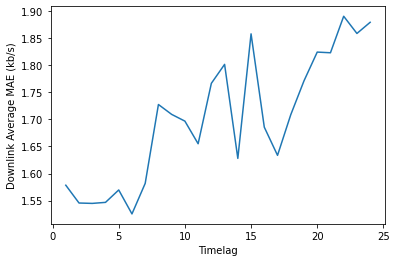

In [25]:
plt.plot(dl_window['timelag'],dl_window['original_mae'])
plt.xlabel('Timelag')
plt.ylabel('Downlink Average MAE (kb/s)')
plt.show()

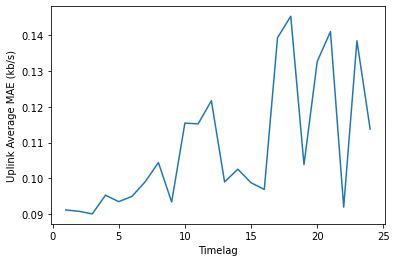

In [26]:
plt.plot(ul_window['timelag'],ul_window['original_mse'])
plt.xlabel('Timelag')
plt.ylabel('Uplink Average MAE (kb/s)')
plt.show()

In [28]:
ul_window.sort_values('original_mae').head()

,target,timelag,normalized_mae,original_mae,normalized_mse,original_mse,normalized_r_squared,original_r_squared
26,ul_avg,3,0.604703,0.232811,0.608034,0.090126,-17.010348,-17.010347
25,ul_avg,2,0.607185,0.233766,0.612958,0.090856,-11.456977,-11.456976
24,ul_avg,1,0.610556,0.235064,0.615447,0.091225,-12.060204,-12.060205
39,ul_avg,16,0.615042,0.236791,0.654093,0.096953,-3.238940,-3.238940
32,ul_avg,9,0.617401,0.237699,0.630378,0.093438,-9.726938,-9.726938


In [27]:
dl_window.sort_values('normalized_mae').head()

,target,timelag,normalized_mae,original_mae,normalized_mse,original_mse,normalized_r_squared,original_r_squared
5,dl_avg,6,0.598538,1.525404,0.615146,3.995436,-4.030086,-4.030086
2,dl_avg,3,0.606167,1.544847,0.599986,3.896972,-5.783542,-5.783541
1,dl_avg,2,0.606439,1.545541,0.609977,3.961867,-5.803162,-5.803163
3,dl_avg,4,0.606906,1.546730,0.607782,3.947610,-4.313556,-4.313556
4,dl_avg,5,0.615905,1.569664,0.648546,4.212375,-3.272555,-3.272555


## Feature Selection

In [61]:
#pipeline data multivariate
targets = ['dl_avg', 'ul_avg']
selection = ['Correlation', 'SelectKBest', 'RFE', 'SelectFromModel', 'PCA']
n_features = [i for i in range(2, len(data.columns))]
predicted = {
    'target':[],
    'feature_selection':[],
    'n_feature':[],
    'features':[],
    'normalized_mae':[],
    'original_mae':[],
    'normalized_mse':[],
    'original_mse':[],
    'normalized_r_squared':[],
    'original_r_squared':[],
}
for target in targets:
    for select in selection:
        for n_feature in n_features:
            y = data[target]
            X = data.drop(target, axis=1)
            X_cols = X.columns
            #transform X
            transformer = RobustScaler().fit(X)
            X = transformer.transform(X)
            X = pd.DataFrame(X, columns = X_cols)
            #transform y
            y = y.to_numpy().reshape(-1,1)
            transformer = RobustScaler().fit(y)
            y = transformer.transform(y)
            y = pd.DataFrame(data = {f'{target}':y[:,0]})[target]
            if select == 'Correlation':
                X_filtered = feature_selection(X, y, how=select, n_features=n_feature, threshold=None)
            elif select == 'SelectKBest':
                X_filtered = feature_selection(X, y, how=select, k=n_feature, score_func=f_regression)
            elif select == 'RFE':
                estimator = RandomForestRegressor(max_depth=5, random_state=42)
                X_filtered = feature_selection(X, y, how=select, estimator=estimator, n_features_to_select=n_feature, step=0.5)
            elif select == 'PCA':
                X_filtered = feature_selection(X, y, how='PCA', n_components=n_feature, random_state=42)
            else:
                estimator = RandomForestRegressor(max_depth=5, random_state=42)
                X_filtered = feature_selection(X, y, how=select, estimator=estimator, threshold=-np.inf, max_features=n_feature)
            if target == 'dl_avg':
                timelag = 6
            else:
                timelag = 3
            X_tr, y_tr, X_test, y_test = split_data(X_filtered, y, train_perc, timelag)
            X_tr, y_tr = windowing_dataset(X_tr, y_tr, timelag, 'multivariate')
            X_test, y_test = windowing_dataset(X_test, y_test, timelag, 'multivariate')
            model = tf.keras.Sequential([
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(units=8, activation='relu'),
                tf.keras.layers.Dense(units=4, activation='relu'),
                tf.keras.layers.Dense(units=1)
            ])
            history = compile_and_fit(model, X_tr, y_tr, epochs=10000, verbose=0)
            predict = model.predict(X_test)
            #evaluate
            eval_result = evaluate(y_test, predict, transformer)
            #to make dataframe later
            predicted['target'].append(target)
            predicted['feature_selection'].append(select)
            predicted['n_feature'].append(n_feature)
            predicted['features'].append(X_filtered.columns)
            predicted['normalized_mae'].append(eval_result['norm_mae'])
            predicted['original_mae'].append(eval_result['ori_mae'])
            predicted['normalized_mse'].append(eval_result['norm_mse'])
            predicted['original_mse'].append(eval_result['ori_mse'])
            predicted['normalized_r_squared'].append(eval_result['norm_r_squared'])
            predicted['original_r_squared'].append(eval_result['ori_r_squared'])

In [62]:
feature_df = pd.DataFrame(predicted)
feature_df.to_csv('../exp_results/feature_selection_result.csv', index=False)

In [3]:
feature_df = pd.read_csv('../exp_results/feature_selection_result.csv')
dl_df = feature_df[feature_df['target']=='dl_avg']
ul_df = feature_df[feature_df['target']=='ul_avg']

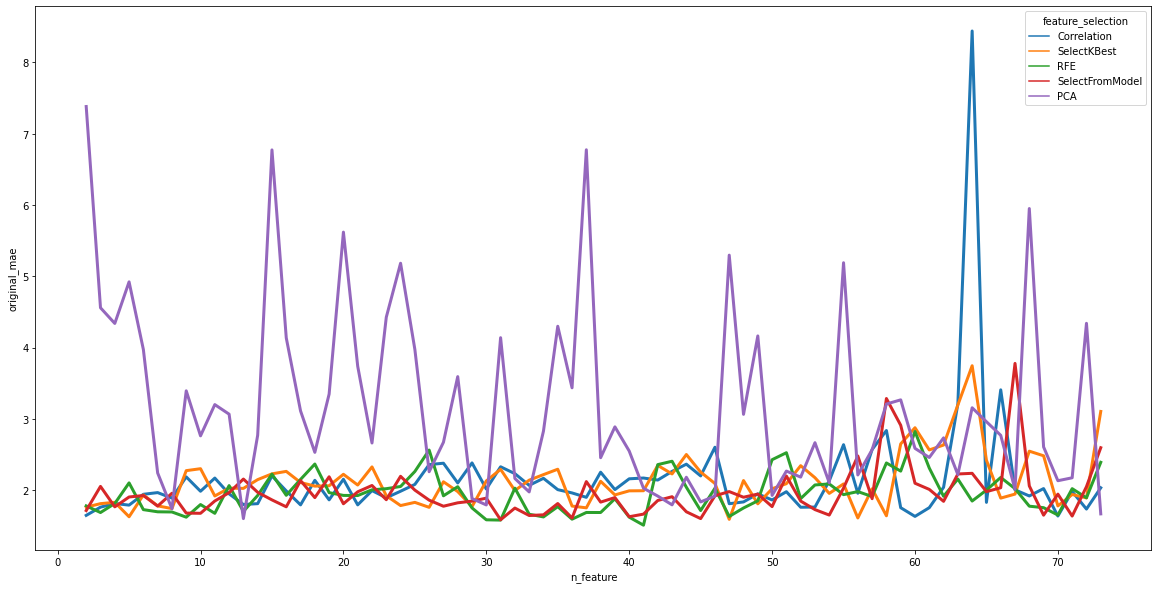

In [83]:
fig, ax = plt.subplots(1,1, figsize=(20,10)) 
sns.lineplot(y='original_mae', x = 'n_feature', data = dl_df, hue='feature_selection', linewidth=3)
plt.show()

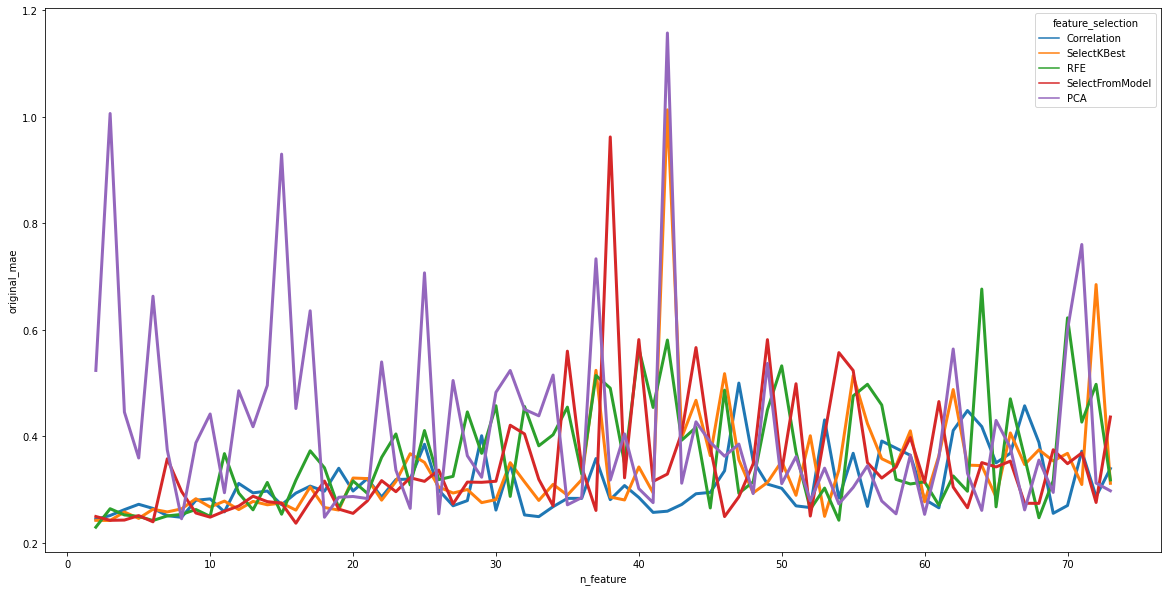

In [84]:
fig, ax = plt.subplots(1,1, figsize=(20,10)) 
sns.lineplot(y='original_mae', x = 'n_feature', data = ul_df, hue='feature_selection', linewidth=3)
plt.show()

<AxesSubplot:xlabel='n_feature', ylabel='original_mae'>

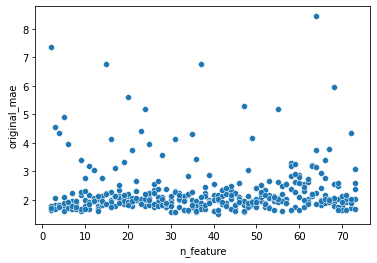

In [65]:
sns.scatterplot(x='n_feature', y='original_mae', data=dl_df)

<AxesSubplot:xlabel='n_feature', ylabel='original_mae'>

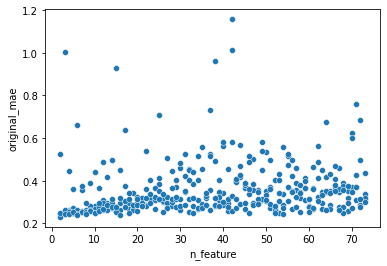

In [66]:
sns.scatterplot(x='n_feature', y='original_mae', data=ul_df)

In [67]:
from sklearn.preprocessing import MultiLabelBinarizer

In [68]:
mlb = MultiLabelBinarizer()
features = mlb.fit_transform(dl_df.sort_values(by='original_mae')[:100]['features'])
features_df = pd.DataFrame(features, columns = list(mlb.classes_))

In [5]:
dl_df

,target,feature_selection,n_feature,features,normalized_mae,original_mae,normalized_mse,original_mse,normalized_r_squared,original_r_squared
0,dl_avg,Correlation,2,Index(['MS_Average PDCP Layer Active Cell Thro...,0.645893,1.646091,0.742357,4.821688,-1.162656,-1.162656
1,dl_avg,Correlation,3,Index(['MS_Average PDCP Layer Active Cell Thro...,0.691067,1.761218,0.875303,5.685187,-1.064185,-1.064185
2,dl_avg,Correlation,4,Index(['MS_Average PDCP Layer Active Cell Thro...,0.711335,1.812872,0.802156,5.210089,-1.610921,-1.610921
3,dl_avg,Correlation,5,Index(['MS_Average PDCP Layer Active Cell Thro...,0.702366,1.790014,0.808264,5.249761,-1.433573,-1.433573
4,dl_avg,Correlation,6,Index(['MS_Average PDCP Layer Active Cell Thro...,0.761910,1.941765,0.994013,6.456218,-1.011673,-1.011673
...,...,...,...,...,...,...,...,...,...,...
355,dl_avg,PCA,69,"Index(['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pc...",1.022542,2.605999,4.529699,29.420878,-0.094424,-0.094424
356,dl_avg,PCA,70,"Index(['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pc...",0.836655,2.132258,3.698700,24.023455,-0.392122,-0.392122
357,dl_avg,PCA,71,"Index(['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pc...",0.852809,2.173427,2.060113,13.380656,-0.722866,-0.722866
358,dl_avg,PCA,72,"Index(['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pc...",1.702885,4.339888,25.347890,164.637265,-0.020012,-0.020012


In [69]:
features_df.sum().sort_values(ascending=False).head(10)

MS_Average PDCP Layer Active Cell Throughput DL(number)          94
MS_RBLER-DL_NOM(number)                                          92
Average eNodeB RB utilization UL_LTE(%)                          76
Maximum eNodeB RB utilization DL_LTE(%)                          75
Packet Delay Budget (UE to PGW)                                  74
MS_Average PDCP Layer Active Cell Throughput UL_DENOM(number)    73
Maximum eNodeB RB utilization DL (Nom)(number)                   72
Average eNodeB RB utilization UL (Nom)(number)                   72
MS_L.Traffic.ActiveUser.Max(number)                              71
IRAT Redir Success Rate_NOM_LTE(number)                          71
dtype: int64

In [70]:
mlb = MultiLabelBinarizer()
features = mlb.fit_transform(ul_df.sort_values(by='original_mae')[:100]['features'])
features_df = pd.DataFrame(features, columns = list(mlb.classes_))

In [71]:
features_df.sum().sort_values(ascending=False).head(10)

MS_Average PDCP Layer Active Cell Throughput UL(number)        87
ul_peak                                                        76
MS_Average PDCP Layer Active Cell Throughput DL(number)        67
dl_peak                                                        64
MS_Volume Traffic UL (MB)(MB)                                  56
MS_Average PDCP Layer Active Cell Throughput UL_NOM(number)    54
dl_avg                                                         51
Packet Delay Budget (UE to PGW) (Nom)(number)                  49
Inter-eNB HO Success Ratio (X2-Based)_new_DENOM_LTE(number)    48
Total Traffic_LTE(MB)                                          47
dtype: int64

In [85]:
dl_df.sort_values(by='original_mae').head()[['feature_selection', 'n_feature', 'original_mae', 'original_mse', 'original_r_squared']]

,feature_selection,n_feature,original_mae,original_mse,original_r_squared
183,RFE,41,1.508608,3.827841,-2.943765
173,RFE,31,1.579981,4.373510,-2.776092
172,RFE,30,1.583983,4.322792,-3.576389
245,SelectFromModel,31,1.584499,4.222996,-2.797575
117,SelectKBest,47,1.590741,4.543679,-1.797895


In [86]:
ul_df.sort_values(by='original_mae').head()[['feature_selection', 'n_feature', 'original_mae', 'original_mse', 'original_r_squared']]

,feature_selection,n_feature,original_mae,original_mse,original_r_squared
504,RFE,2,0.229081,0.089034,-10.868927
590,SelectFromModel,16,0.236552,0.095352,-9.290708
580,SelectFromModel,6,0.239176,0.094435,-17.205558
508,RFE,6,0.241630,0.097171,-34.588943
433,SelectKBest,3,0.241695,0.096605,-33.015840


## Model Selection

In [77]:
#pipeline data univariate
train_perc = 0.8
targets = ['dl_avg', 'ul_avg']
predicted = {
    'target':[],
    'model':[],
    'normalized_mae':[],
    'original_mae':[],
    'normalized_mse':[],
    'original_mse':[],
    'normalized_r_squared':[],
    'original_r_squared':[]
}


for target in targets:
    if target == 'dl_avg':
        timelag = 6
    else:
        timelag = 3
    transformer = RobustScaler().fit(data[target].to_numpy().reshape(-1, 1))
    norm = transformer.transform(data[target].to_numpy().reshape(-1, 1))
    X, y = pd.Series(norm[:,0]), pd.Series(norm[:,0])
    X_tr, y_tr, X_test, y_test = split_data(X, y, train_perc, timelag)
    X_tr, y_tr = windowing_dataset(X_tr, y_tr, timelag, 'univariate')
    X_test, y_test = windowing_dataset(X_test, y_test, timelag, 'univariate')
    models = {
        'LSTM' : tf.keras.Sequential([
                    tf.keras.layers.LSTM(8, return_sequences=True, activation='relu'),
                    tf.keras.layers.LSTM(4, activation='relu'),
                    tf.keras.layers.Dense(1)
                ]),
        'dense' : tf.keras.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(units=8, activation='relu'),
            tf.keras.layers.Dense(units=4, activation='relu'),
            tf.keras.layers.Dense(units=1)
        ])
    }
    for model in models:
        history = compile_and_fit(models[model], X_tr, y_tr, epochs=10000, verbose=0)
        predict = models[model].predict(X_test)
        #evaluate
        eval_result = evaluate(y_test, predict, transformer)          
        #to make dataframe later
        predicted['target'].append(target)
        predicted['model'].append(model)
        predicted['normalized_mae'].append(eval_result['norm_mae'])
        predicted['original_mae'].append(eval_result['ori_mae'])
        predicted['normalized_mse'].append(eval_result['norm_mse'])
        predicted['original_mse'].append(eval_result['ori_mse'])
        predicted['normalized_r_squared'].append(eval_result['norm_r_squared'])
        predicted['original_r_squared'].append(eval_result['ori_r_squared'])
        

In [78]:
pd.DataFrame(predicted).to_csv('../exp_results/model_selection_univariate_result.csv', index=False)

In [81]:
uni_model = pd.read_csv('../exp_results/model_selection_univariate_result.csv')
uni_model[['target', 'model', 'original_mae', 'original_mse', 'original_r_squared']]

,target,model,original_mae,original_mse,original_r_squared
0,dl_avg,LSTM,1.512087,3.819040,-5.314586
1,dl_avg,dense,1.574129,4.170609,-2.077879
2,ul_avg,LSTM,0.240050,0.094618,-11.773524
3,ul_avg,dense,0.247231,0.099209,-40.978194


In [87]:
#pipeline data multivariate
targets = ['dl_avg', 'ul_avg']
predicted = {
    'target':[],
    'model':[],
    'normalized_mae':[],
    'original_mae':[],
    'normalized_mse':[],
    'original_mse':[],
    'normalized_r_squared':[],
    'original_r_squared':[]
}
for target in targets:
    if target == 'dl_avg':
        select = 'RFE'
        timelag = 6
        n_feature = 41
    else:
        select = 'RFE'
        timelag = 3
        n_feature = 2
        
    y = data[target]
    X = data.drop(target, axis=1)
    X_cols = X.columns
    #transform X
    transformer = RobustScaler().fit(X)
    X = transformer.transform(X)
    X = pd.DataFrame(X, columns = X_cols)
    #transform y
    y = y.to_numpy().reshape(-1,1)
    transformer = RobustScaler().fit(y)
    y = transformer.transform(y)
    y = pd.DataFrame(data = {f'{target}':y[:,0]})[target]
    if select == 'Correlation':
        X_filtered = feature_selection(X, y, how=select, n_features=n_feature, threshold=None)
    elif select == 'SelectKBest':
        X_filtered = feature_selection(X, y, how=select, k=n_feature, score_func=f_regression)
    elif select == 'RFE':
        estimator = RandomForestRegressor(max_depth=5, random_state=42)
        X_filtered = feature_selection(X, y, how=select, estimator=estimator, n_features_to_select=n_feature, step=0.5)
    elif select == 'PCA':
        X_filtered = feature_selection(X, y, how='PCA', n_components=n_feature, random_state=42)
    else:
        estimator = RandomForestRegressor(max_depth=5, random_state=42)
        X_filtered = feature_selection(X, y, how=select, estimator=estimator, threshold=-np.inf, max_features=n_feature)
        
    X_tr, y_tr, X_test, y_test = split_data(X_filtered, y, train_perc, timelag)
    X_tr, y_tr = windowing_dataset(X_tr, y_tr, timelag, 'multivariate')
    X_test, y_test = windowing_dataset(X_test, y_test, timelag, 'multivariate')
    models = {
        'LSTM' : tf.keras.Sequential([
                    tf.keras.layers.LSTM(8, return_sequences=True, activation='relu'),
                    tf.keras.layers.LSTM(4, activation='relu'),
                    tf.keras.layers.Dense(1)
                ]),
        'dense' : tf.keras.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(units=8, activation='relu'),
            tf.keras.layers.Dense(units=4, activation='relu'),
            tf.keras.layers.Dense(units=1)
        ])
    }
    for model in models:
        history = compile_and_fit(models[model], X_tr, y_tr, epochs=10000, verbose=0)
        predict = models[model].predict(X_test)
        #evaluate
        eval_result = evaluate(y_test, predict, transformer)          
        #to make dataframe later
        predicted['target'].append(target)
        predicted['model'].append(model)
        predicted['normalized_mae'].append(eval_result['norm_mae'])
        predicted['original_mae'].append(eval_result['ori_mae'])
        predicted['normalized_mse'].append(eval_result['norm_mse'])
        predicted['original_mse'].append(eval_result['ori_mse'])
        predicted['normalized_r_squared'].append(eval_result['norm_r_squared'])
        predicted['original_r_squared'].append(eval_result['ori_r_squared'])

In [88]:
pd.DataFrame(predicted).to_csv('../exp_results/model_selection_multivariable.csv', index=False)

In [90]:
multi_model = pd.read_csv('../exp_results/model_selection_multivariable.csv')
multi_model[['target', 'model', 'original_mae', 'original_mse', 'original_r_squared']]

,target,model,original_mae,original_mse,original_r_squared
0,dl_avg,LSTM,2.653416,13.336539,-0.709862
1,dl_avg,dense,1.624475,4.451765,-3.009471
2,ul_avg,LSTM,0.240236,0.094640,-14.698219
3,ul_avg,dense,0.254688,0.103228,-20.290323


# Buat nyoba satu persatu

## Univariable

In [144]:
#pipeline data univariate
target = 'dl_avg'
timelag = 6
result = {}

transformer = RobustScaler().fit(data[target].to_numpy().reshape(-1, 1))
norm = transformer.transform(data[target].to_numpy().reshape(-1, 1))
X, y = pd.Series(norm[:,0]), pd.Series(norm[:,0])
X_tr, y_tr, X_test, y_test = split_data(X, y, train_perc, timelag)
X_tr, y_tr = windowing_dataset(X_tr, y_tr, timelag, 'univariate')
X_test, y_test = windowing_dataset(X_test, y_test, timelag, 'univariate')
models = {
        'LSTM' : tf.keras.Sequential([
                    tf.keras.layers.LSTM(8, return_sequences=True, activation='relu'),
                    tf.keras.layers.LSTM(4, activation='relu'),
                    tf.keras.layers.Dense(1)
                ]),
        'dense' : tf.keras.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(units=8, activation='relu'),
            tf.keras.layers.Dense(units=4, activation='relu'),
            tf.keras.layers.Dense(units=1)
        ])
}
ori_y = transformer.inverse_transform(y_test.reshape(-1,1))
result['y_true'] = list(ori_y[:, 0])
for model in models:
    history = compile_and_fit(models[model], X_tr, y_tr, epochs=10000, verbose=0)
    y_pred = models[model].predict(X_test)
    ori_predict = transformer.inverse_transform(y_pred.reshape(-1,1))
    result[f'{model}_prediction'] = list(ori_predict[:,0])

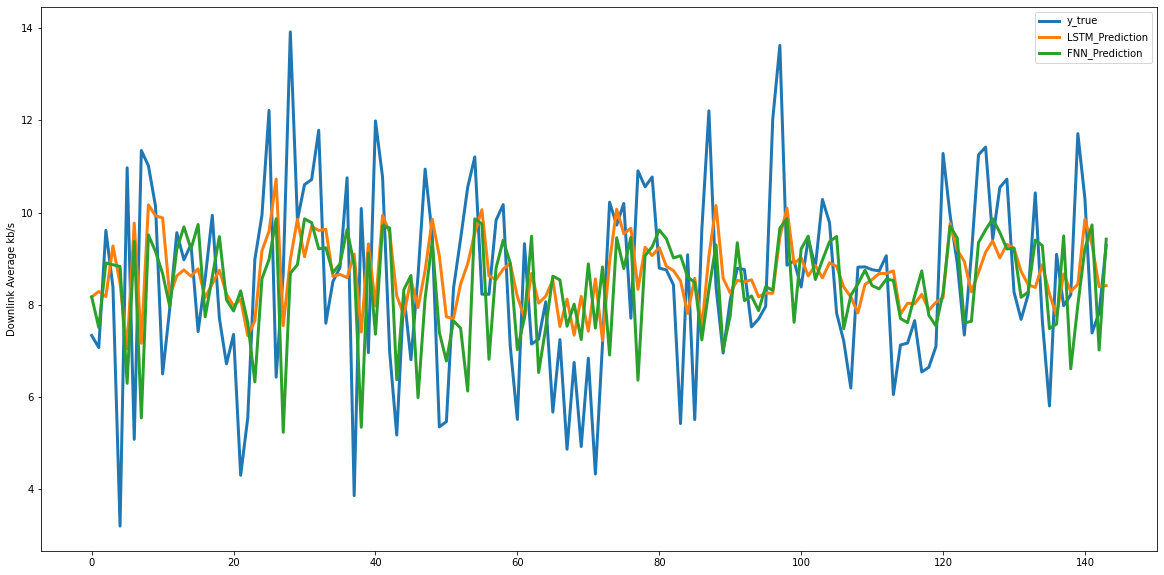

In [145]:
df = pd.DataFrame(result)
plt.plot([i for i in range(len(df))], df['y_true'], linewidth = 3)
plt.plot([i for i in range(len(df))], df['LSTM_prediction'], linewidth = 3)
plt.plot([i for i in range(len(df))], df['dense_prediction'], linewidth = 3)
plt.ylabel('Downlink Average kb/s')
plt.legend(['y_true', 'LSTM_Prediction', 'FNN_Prediction'])
plt.rcParams["figure.figsize"] = (20,10)
#plt.show()

## Multivariable

In [140]:
select = 'RFE'
timelag = 6
n_feature = 41
target = 'dl_avg'
result = {}

y = data[target]
X = data.drop(target, axis=1)
X_cols = X.columns
#transform X
transformer = RobustScaler().fit(X)
X = transformer.transform(X)
X = pd.DataFrame(X, columns = X_cols)
#transform y
y = y.to_numpy().reshape(-1,1)
transformer = RobustScaler().fit(y)
y = transformer.transform(y)
y = pd.DataFrame(data = {f'{target}':y[:,0]})[target]
if select == 'Correlation':
    X_filtered = feature_selection(X, y, how=select, n_features=n_feature, threshold=None)
elif select == 'SelectKBest':
    X_filtered = feature_selection(X, y, how=select, k=n_feature, score_func=f_regression)
elif select == 'RFE':
    estimator = RandomForestRegressor(max_depth=5, random_state=42)
    X_filtered = feature_selection(X, y, how=select, estimator=estimator, n_features_to_select=n_feature, step=0.5)
elif select == 'PCA':
    X_filtered = feature_selection(X, y, how='PCA', n_components=n_feature, random_state=42)
else:
    estimator = RandomForestRegressor(max_depth=5, random_state=42)
    X_filtered = feature_selection(X, y, how=select, estimator=estimator, threshold=-np.inf, max_features=n_feature)

X_tr, y_tr, X_test, y_test = split_data(X_filtered, y, train_perc, timelag)
X_tr, y_tr = windowing_dataset(X_tr, y_tr, timelag, 'multivariate')
X_test, y_test = windowing_dataset(X_test, y_test, timelag, 'multivariate')
models = {
        'LSTM' : tf.keras.Sequential([
                    tf.keras.layers.LSTM(8, return_sequences=True, activation='relu'),
                    tf.keras.layers.LSTM(4, activation='relu'),
                    tf.keras.layers.Dense(1)
                ]),
        'dense' : tf.keras.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(units=8, activation='relu'),
            tf.keras.layers.Dense(units=4, activation='relu'),
            tf.keras.layers.Dense(units=1)
        ])
}
ori_y = transformer.inverse_transform(y_test.reshape(-1,1))
result['y_true'] = list(ori_y[:, 0])
for model in models:
    history = compile_and_fit(models[model], X_tr, y_tr, epochs=10000, verbose=0)
    y_pred = models[model].predict(X_test)
    ori_predict = transformer.inverse_transform(y_pred.reshape(-1,1))
    result[f'{model}_prediction'] = list(ori_predict[:,0])

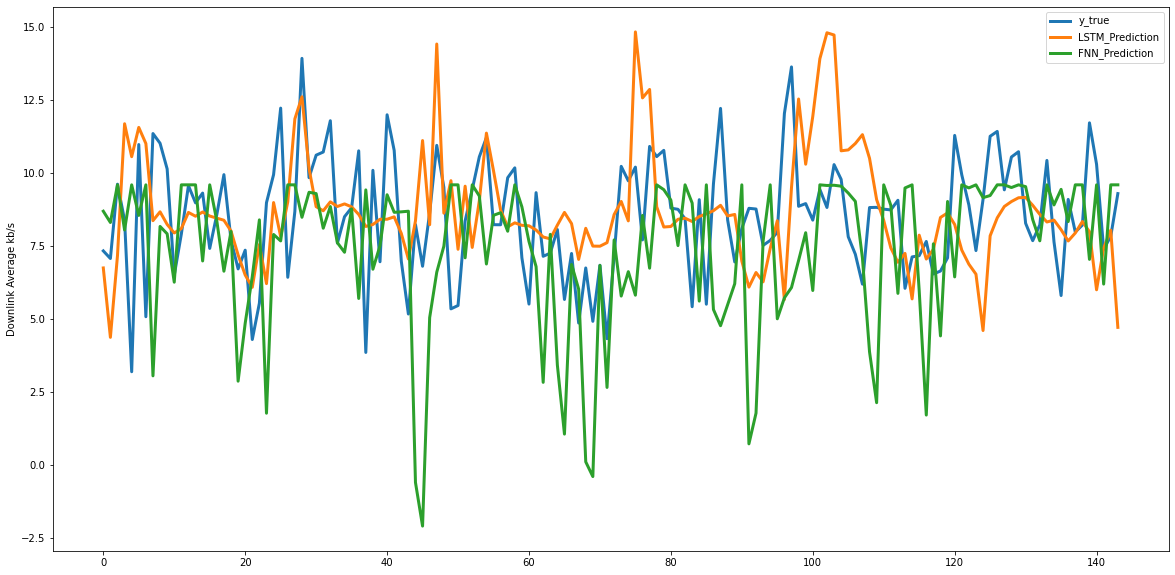

In [141]:
df = pd.DataFrame(result)
plt.plot([i for i in range(len(df))], df['y_true'], linewidth = 3)
plt.plot([i for i in range(len(df))], df['LSTM_prediction'], linewidth = 3)
plt.plot([i for i in range(len(df))], df['dense_prediction'], linewidth = 3)
plt.ylabel('Downlink Average kb/s')
plt.legend(['y_true', 'LSTM_Prediction', 'FNN_Prediction'])
plt.rcParams["figure.figsize"] = (20,10)
#plt.show()

In [109]:
select = 'RFE'
timelag = 3
n_feature = 2
target = 'ul_avg'

y = data[target]
X = data.drop(target, axis=1)
X_cols = X.columns
#transform X
transformer = RobustScaler().fit(X)
X = transformer.transform(X)
X = pd.DataFrame(X, columns = X_cols)
#transform y
y = y.to_numpy().reshape(-1,1)
transformer = RobustScaler().fit(y)
y = transformer.transform(y)
y = pd.DataFrame(data = {f'{target}':y[:,0]})[target]
if select == 'Correlation':
    X_filtered = feature_selection(X, y, how=select, n_features=n_feature, threshold=None)
elif select == 'SelectKBest':
    X_filtered = feature_selection(X, y, how=select, k=n_feature, score_func=f_regression)
elif select == 'RFE':
    estimator = RandomForestRegressor(max_depth=5, random_state=42)
    X_filtered = feature_selection(X, y, how=select, estimator=estimator, n_features_to_select=n_feature, step=0.5)
elif select == 'PCA':
    X_filtered = feature_selection(X, y, how='PCA', n_components=n_feature, random_state=42)
else:
    estimator = RandomForestRegressor(max_depth=5, random_state=42)
    X_filtered = feature_selection(X, y, how=select, estimator=estimator, threshold=-np.inf, max_features=n_feature)

X_tr, y_tr, X_test, y_test = split_data(X_filtered, y, train_perc, timelag)
X_tr, y_tr = windowing_dataset(X_tr, y_tr, timelag, 'multivariate')
X_test, y_test = windowing_dataset(X_test, y_test, timelag, 'multivariate')
model = tf.keras.Sequential([
            tf.keras.layers.LSTM(8, return_sequences=True),
            tf.keras.layers.LSTM(4),
            tf.keras.layers.Dense(1)
        ])

history = compile_and_fit(model, X_tr, y_tr, epochs=10000, verbose=0)
y_pred = model.predict(X_test)

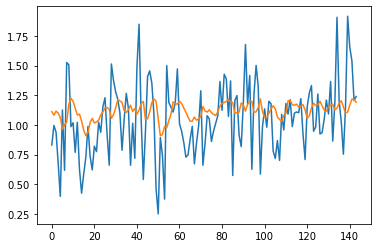

In [110]:
ori_predict = transformer.inverse_transform(y_pred.reshape(-1,1))
ori_y = transformer.inverse_transform(y_test.reshape(-1,1))
plt.plot([i for i in range(len(ori_y))], ori_y)
plt.plot([i for i in range(len(ori_predict))], ori_predict)